In [1]:
using Revise

using FileIO, JLD2, LinearAlgebra, StaticArrays, StatsBase, Random, BenchmarkTools, Colors, ThreadsX, DataStructures
using ProgressMeter
using CairoMakie; set_theme!(size = (800,600))
using Utilities; ProgressMeter.ijulia_behavior(:append)

using Challengers; const ch = Challengers;

Precompiling Challengers
  ✓ Challengers
  1 dependency successfully precompiled in 3 seconds. 26 already precompiled.


In [98]:
function runGame(forcedcards = nothing; nplayers = 8, fixcards = true)
    pile = CardPile()
    players = [Player() for i in 1:nplayers]
    forcedcards = (isnothing(forcedcards) ? fill(Card[], nplayers) : forcedcards)
    forcedcards = sort.(forcedcards, by = tier, rev = true)
    
    state = State()
    for (round, tier, npicks) in zip(1:7, [ch.A, ch.A, ch.B, ch.B, ch.B, ch.C, ch.C], [2, 2, 1, 2, 2, 1, 2])
        for i in shuffle(1:nplayers)
            cards = forcedcards[i]; player = players[i]
            while !isempty(cards) && last(cards).tier == tier && npicks > 0
                push!(player.deck, pop!(cards), fix = fixcards)
                npicks -= 1
            end
            pickCards!(player.deck, pile, tier, npicks, state = state)
        end
        for (i, j) in eachcol(reshape(shuffle(1:nplayers), 2, :))
            play!(players[i], players[j], round, state = state)
        end
    end
    for player in players
        optimize!(player.deck, nsamples = 5)
    end
    trophyvalues = [2,3,4,5,6,7,10]
    points = [player.fans + sum(trophyvalues[player.trophies]) for player in players]
    contenders = sortperm(points, rev = true)[1:2]
    winner = play!(players[contenders[1]], players[contenders[2]], 0).winner
    contenders[winner], points, players
end

runGame (generic function with 2 methods)

In [101]:
@benchmark runGame()

BenchmarkTools.Trial: 297 samples with 1 evaluation.
 Range (min … max):  13.285 ms … 43.724 ms  ┊ GC (min … max): 0.00% … 47.09%
 Time  (median):     16.126 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.838 ms ±  3.423 ms  ┊ GC (mean ± σ):  1.21% ±  4.99%

      ▁▂ ▄█                                                    
  ▅▄▅▆████████▄▅▆▄▄▃▃▄▁▃▂▁▂▃▁▂▁▁▁▂▃▁▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▃
  13.3 ms         Histogram: frequency by time          33 ms <

 Memory estimate: 5.55 MiB, allocs estimate: 59926.

In [86]:
abccards = [Acards; Bcards; Ccards]
nwins = zeros(Int, length(abccards))
nplays = zeros(Int, length(abccards))
nplayers = 8

lk = ReentrantLock()

nsamples = 100000
prog = Progress(nsamples)
Threads.@threads for i in 1:nsamples
    tiercards = rand([Acards, Bcards, Ccards])
    forced = [rand(tiercards, 1) for i in 1:nplayers]
    winner, points, players = runGame(forced, nplayers = nplayers, fixcards = true);

    lock(lk) do 
        nwins[findfirst(isequal(forced[winner][1]), abccards)] += 1
        for i in 1:nplayers
            nplays[findfirst(isequal(forced[i][1]), abccards)] += 1
        end
    end
    next!(prog)
end

winrates = nwins ./ nplays;
winodds = winrates ./ (1 .- winrates);

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:08:49


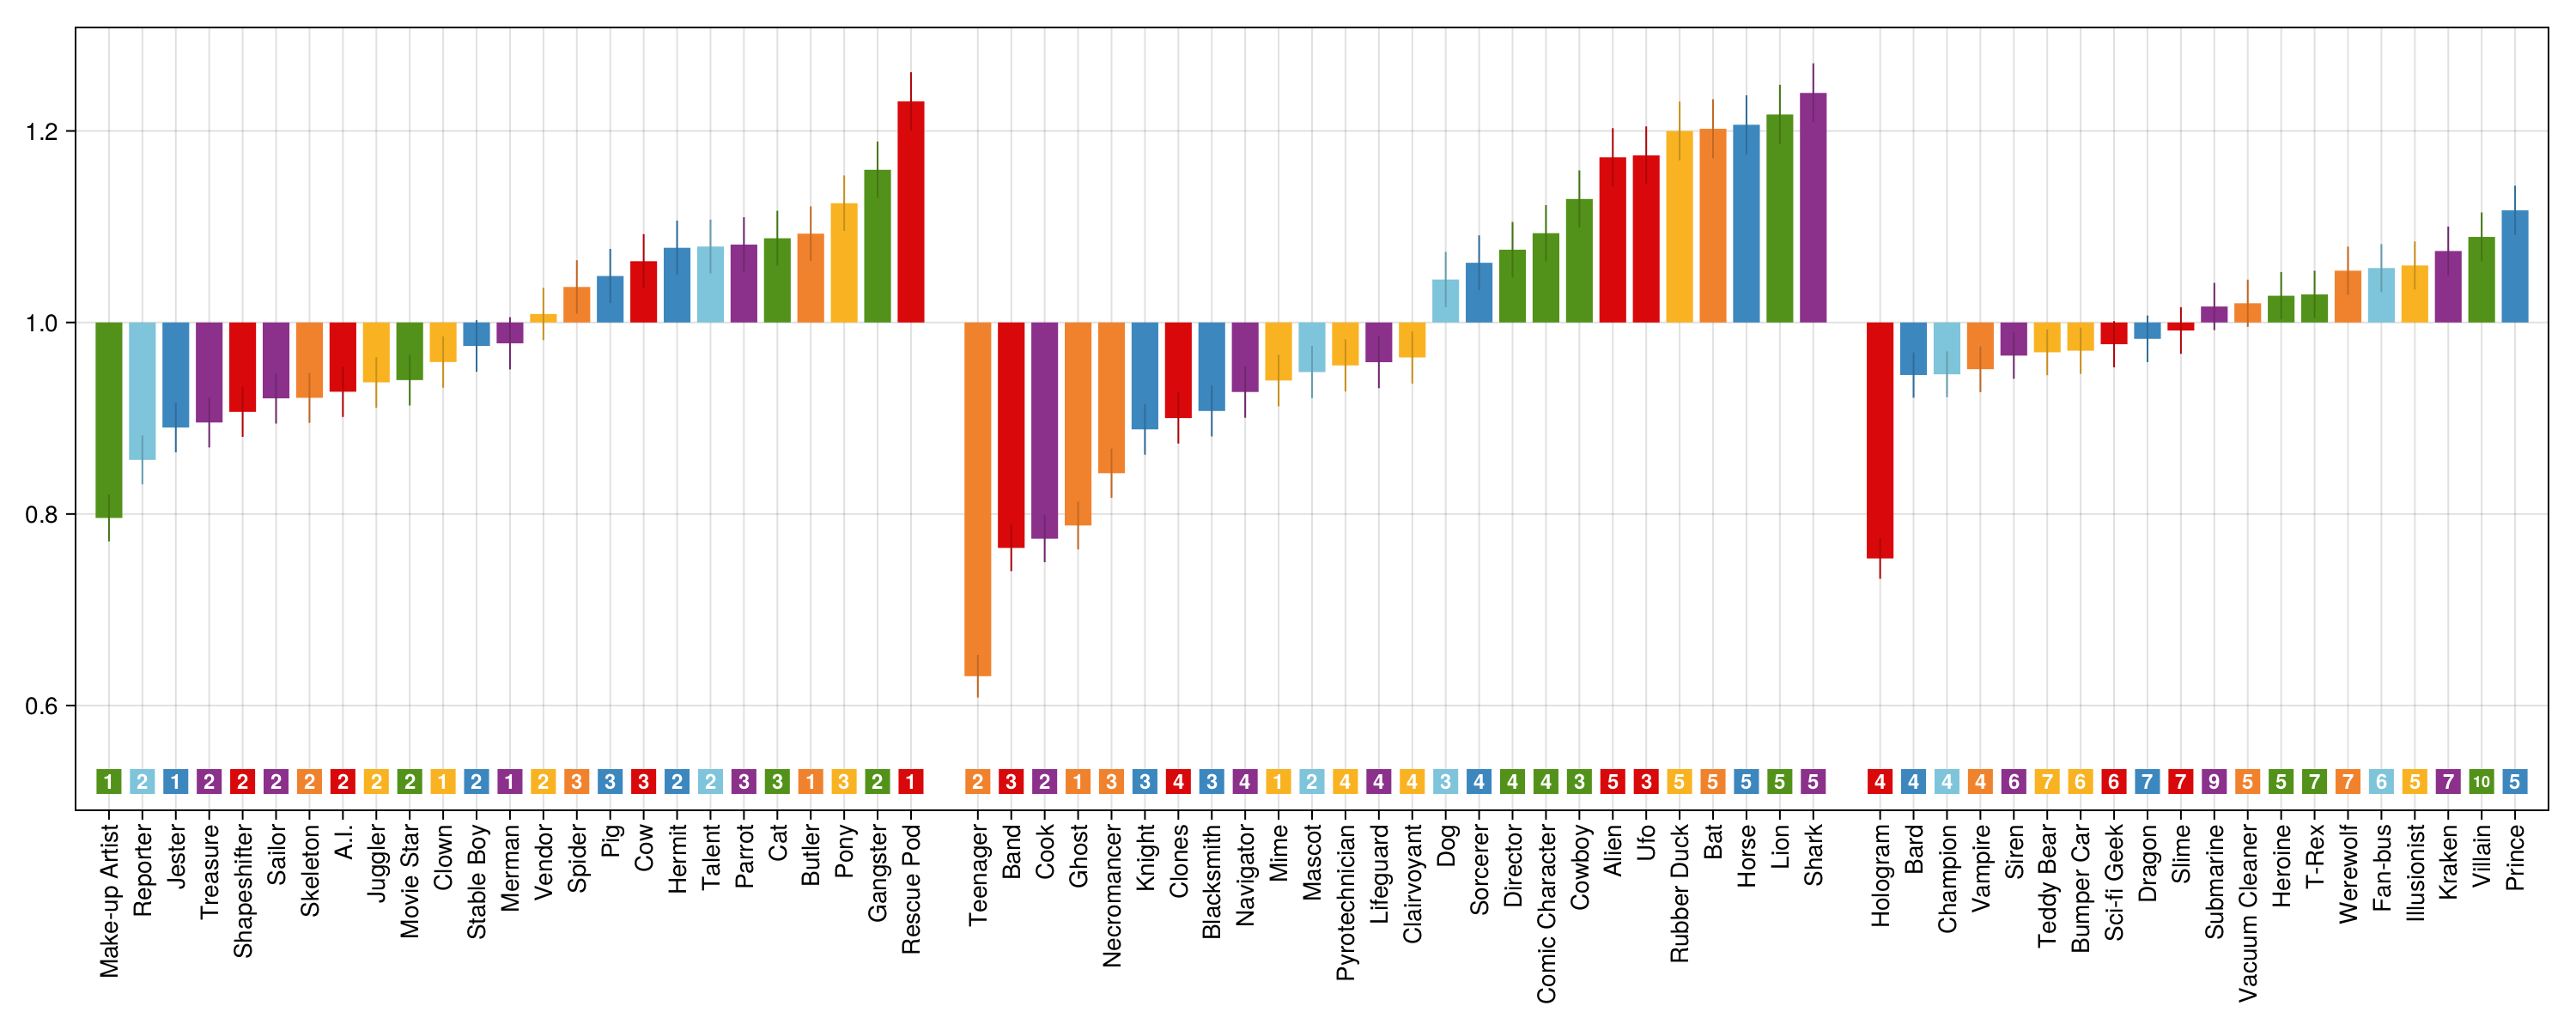

In [87]:
# ucards = copy(abccards)
ucards = abccards[sort(1:length(abccards), by = i -> (tier(abccards[i]), winrates[i]))]
# sort!(ucards, by = set)
i = 2
while i <= length(ucards)
    a = false#ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end

uinds = findfirst.(isequal.(abccards), Ref(ucards))
unplays = fill(NaN, length(ucards))
unplays[uinds] .= nplays;
unwins = fill(NaN, length(ucards))
unwins[uinds] .= nwins;
uwinrates = unwins ./ unplays;
uwinodds = uwinrates ./ (1 .- uwinrates);

fig = Figure(size = (1500,600))
xs = 1:length(ucards)
ax = Axis(fig[1,1], xticks = (xs[(!isempty).(name.(ucards))], name.(ucards)[(!isempty).(name.(ucards))]), xticklabelrotation = pi/2)

barplot!(ax, xs, nplayers .* uwinrates, linewidth = 3, color = setcolor.(ucards), fillto = 1)
errorbars!(ax, xs, nplayers .* uwinrates, nplayers .* sqrt.(uwinrates ./ unplays), linewidth = 1, color = parse.(RGB, setcolor.(ucards)) .* 0.8, whiskerwidth = 0)

scatter!(ax, 1:length(ucards), fill(8minimum(winrates)-0.11, length(ucards)), color = setcolor.(ucards), marker = :rect, markersize = 23)
ts = string.(power.(ucards))
text!(ax, 1:length(ucards), fill(8minimum(winrates)-0.11, length(ucards)), text = ts, color = :white, fontsize = ifelse.(length.(ts) .== 1, 12, 9), align = (:center, :center), font = :bold)

xlims!(ax, 0, length(ucards)+1)
ylims!(ax, low = 8minimum(winrates)-0.14)

fig

In [83]:
save(numpath("out/fullgamewinrates.pdf"), fig)

CairoMakie.Screen{PDF}


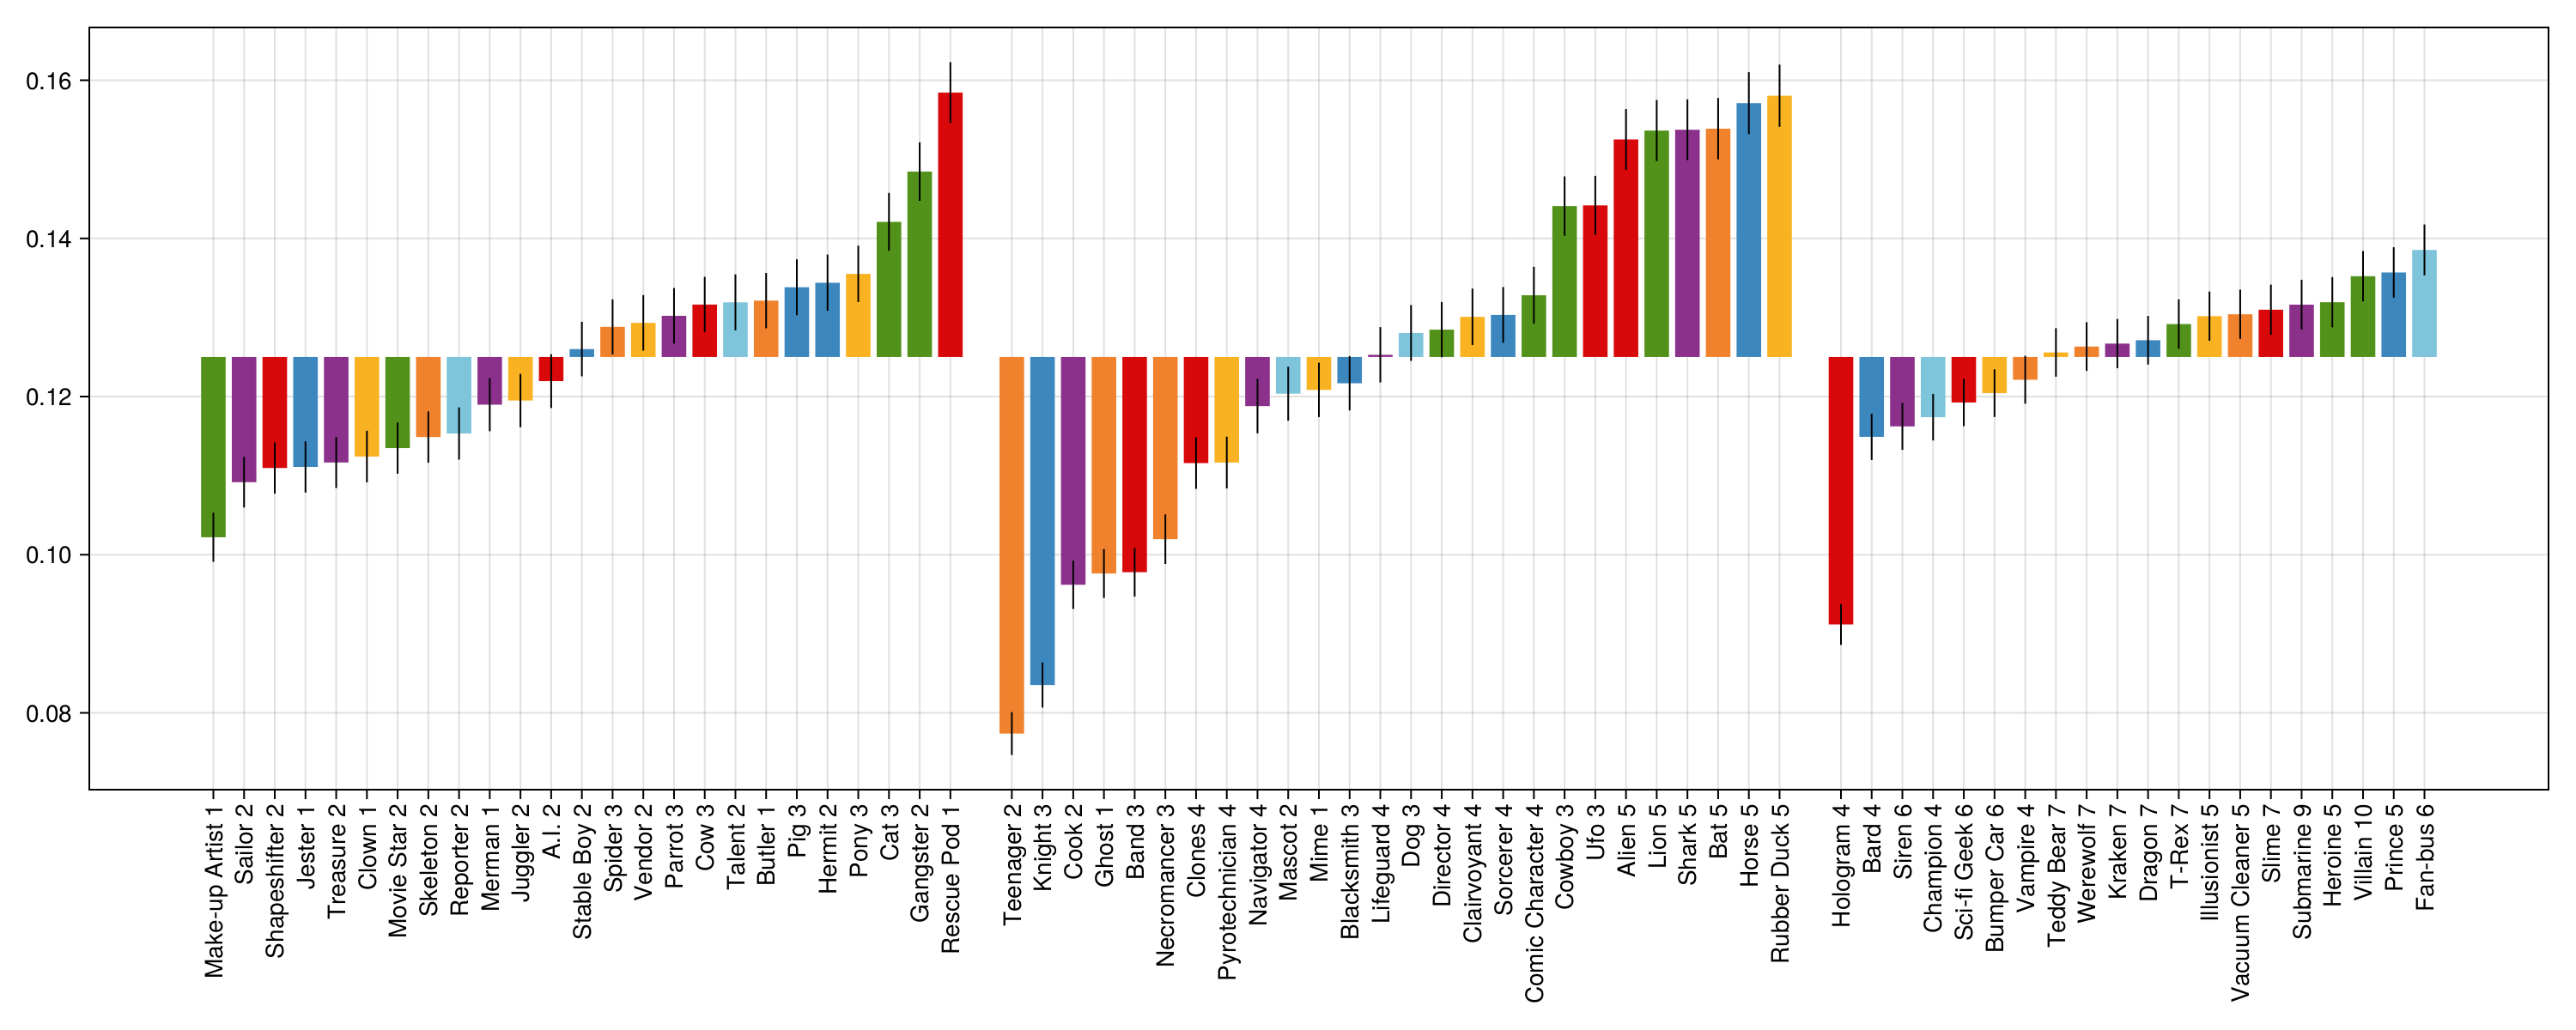

In [120]:
# ucards = copy(abccards)
ucards = abccards[sort(1:length(abccards), by = i -> (tier(abccards[i]), winrates[i]))]
# sort!(ucards, by = set)
i = 2
while i <= length(ucards)
    a = false#ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end

uinds = findfirst.(isequal.(abccards), Ref(ucards))
unplays = fill(NaN, length(ucards))
unplays[uinds] .= nplays;
unwins = fill(NaN, length(ucards))
unwins[uinds] .= nwins;
uwinrates = unwins ./ unplays;
uwinodds = uwinrates ./ (1 .- uwinrates);

fig = Figure(size = (1500,600))
xs = 1:length(ucards)
ax = Axis(fig[1,1], xticks = (xs[(!isempty).(name.(ucards))], (name.(ucards) .* " " .* string.(power.(ucards)))[(!isempty).(name.(ucards))]), xticklabelrotation = pi/2)

barplot!(ax, xs, uwinrates, linewidth = 3, color = setcolor.(ucards), fillto = 1/nplayers)
errorbars!(ax, xs, uwinrates, sqrt.(uwinrates ./ unplays), linewidth = 1, color = :black, whiskerwidth = 0)

fig

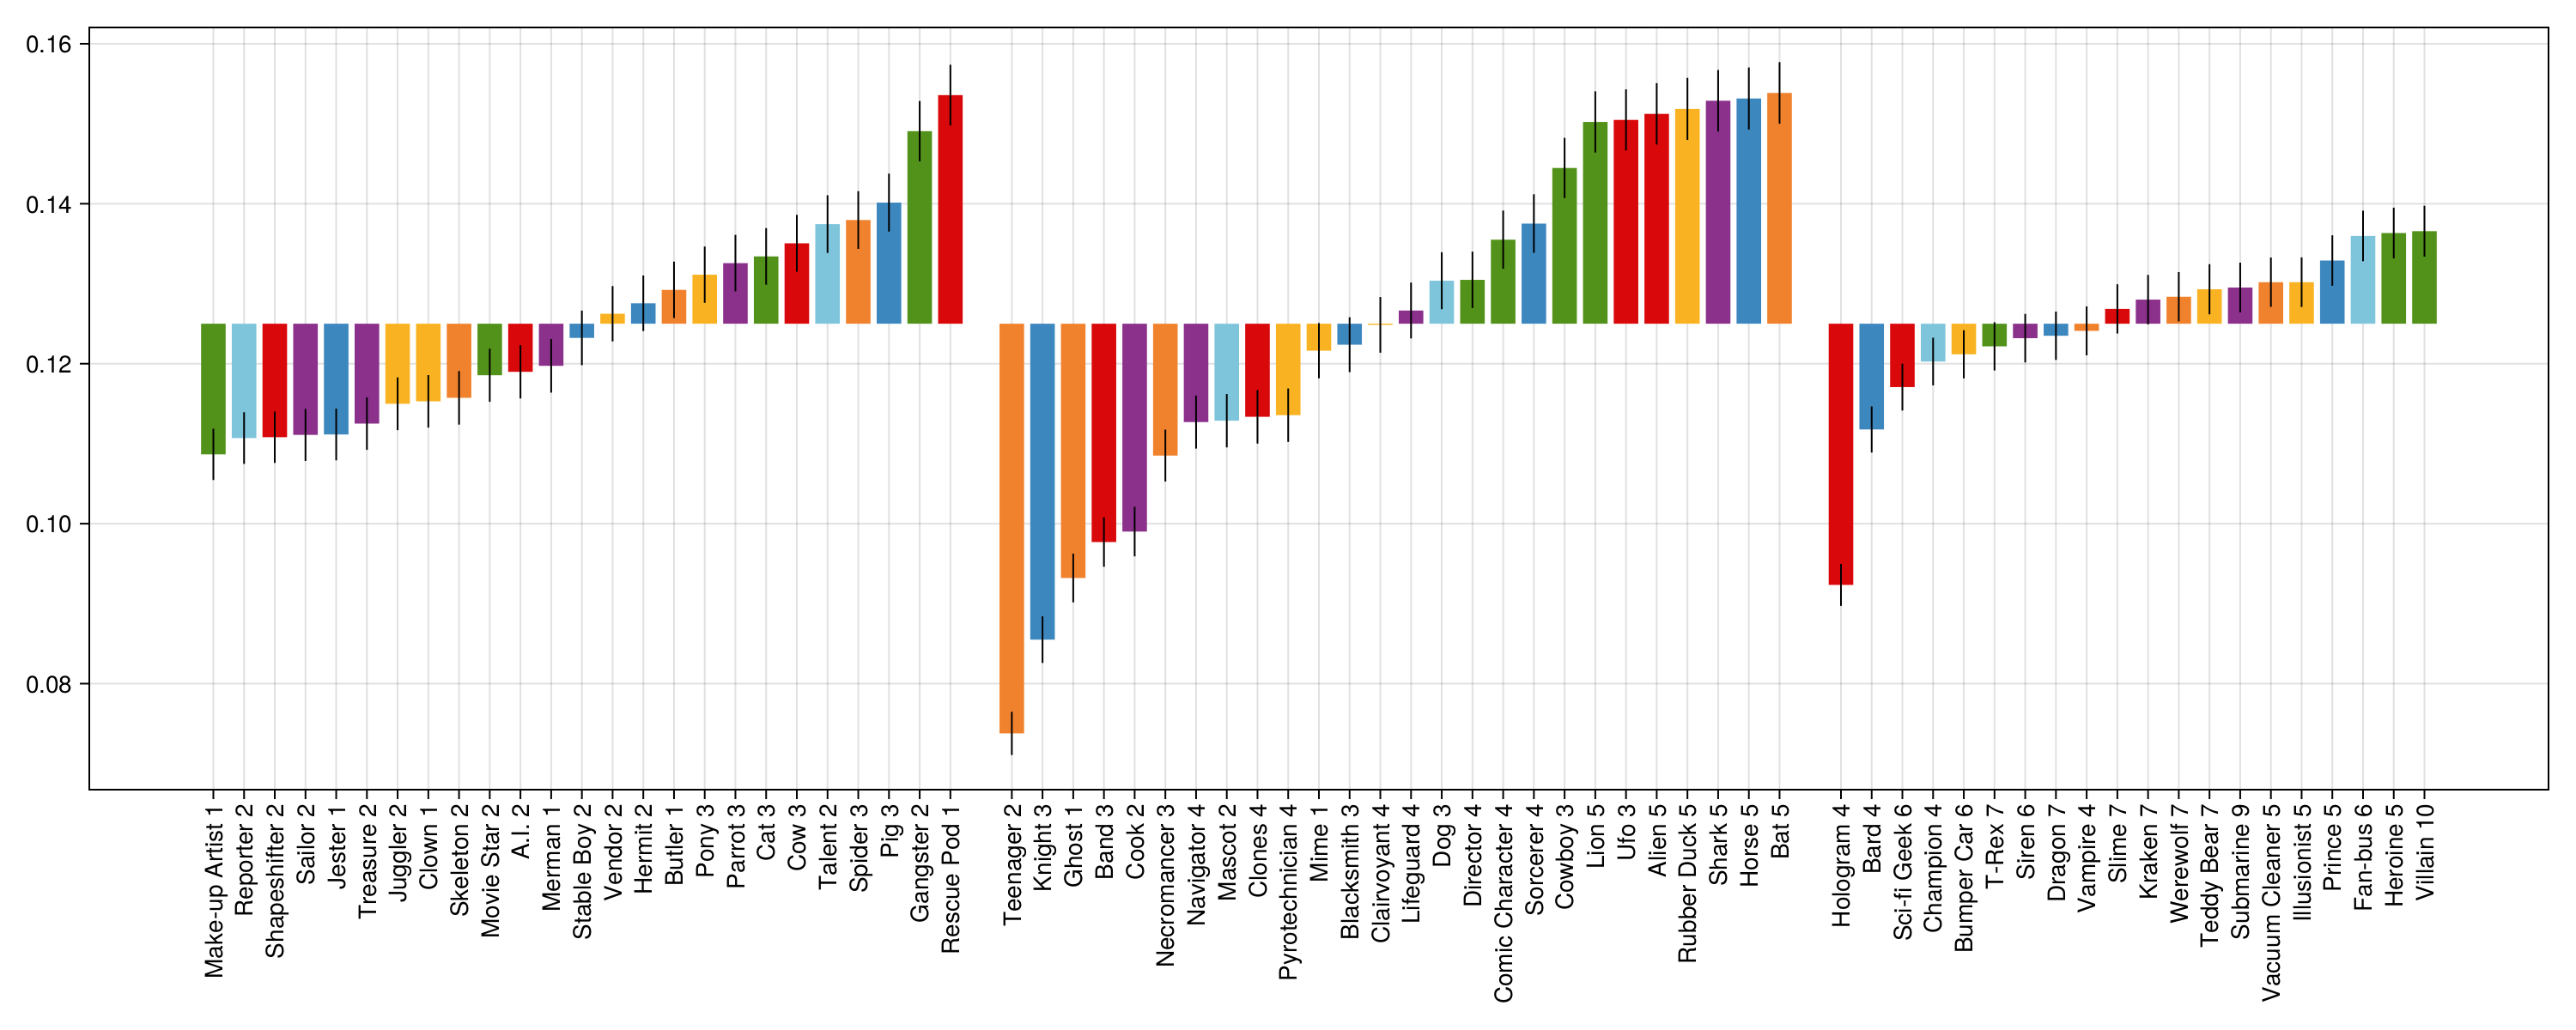

In [83]:
# ucards = copy(abccards)
ucards = abccards[sort(1:length(abccards), by = i -> (tier(abccards[i]), winrates[i]))]
# sort!(ucards, by = set)
i = 2
while i <= length(ucards)
    a = false#ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end

uinds = findfirst.(isequal.(abccards), Ref(ucards))
unplays = fill(NaN, length(ucards))
unplays[uinds] .= nplays;
unwins = fill(NaN, length(ucards))
unwins[uinds] .= nwins;
uwinrates = unwins ./ unplays;
uwinodds = uwinrates ./ (1 .- uwinrates);

fig = Figure(size = (1500,600))
xs = 1:length(ucards)
ax = Axis(fig[1,1], xticks = (xs[(!isempty).(name.(ucards))], (name.(ucards) .* " " .* string.(power.(ucards)))[(!isempty).(name.(ucards))]), xticklabelrotation = pi/2)

barplot!(ax, xs, uwinrates, linewidth = 3, color = setcolor.(ucards), fillto = 1/nplayers)
errorbars!(ax, xs, uwinrates, sqrt.(uwinrates ./ unplays), linewidth = 1, color = :black, whiskerwidth = 0)

fig

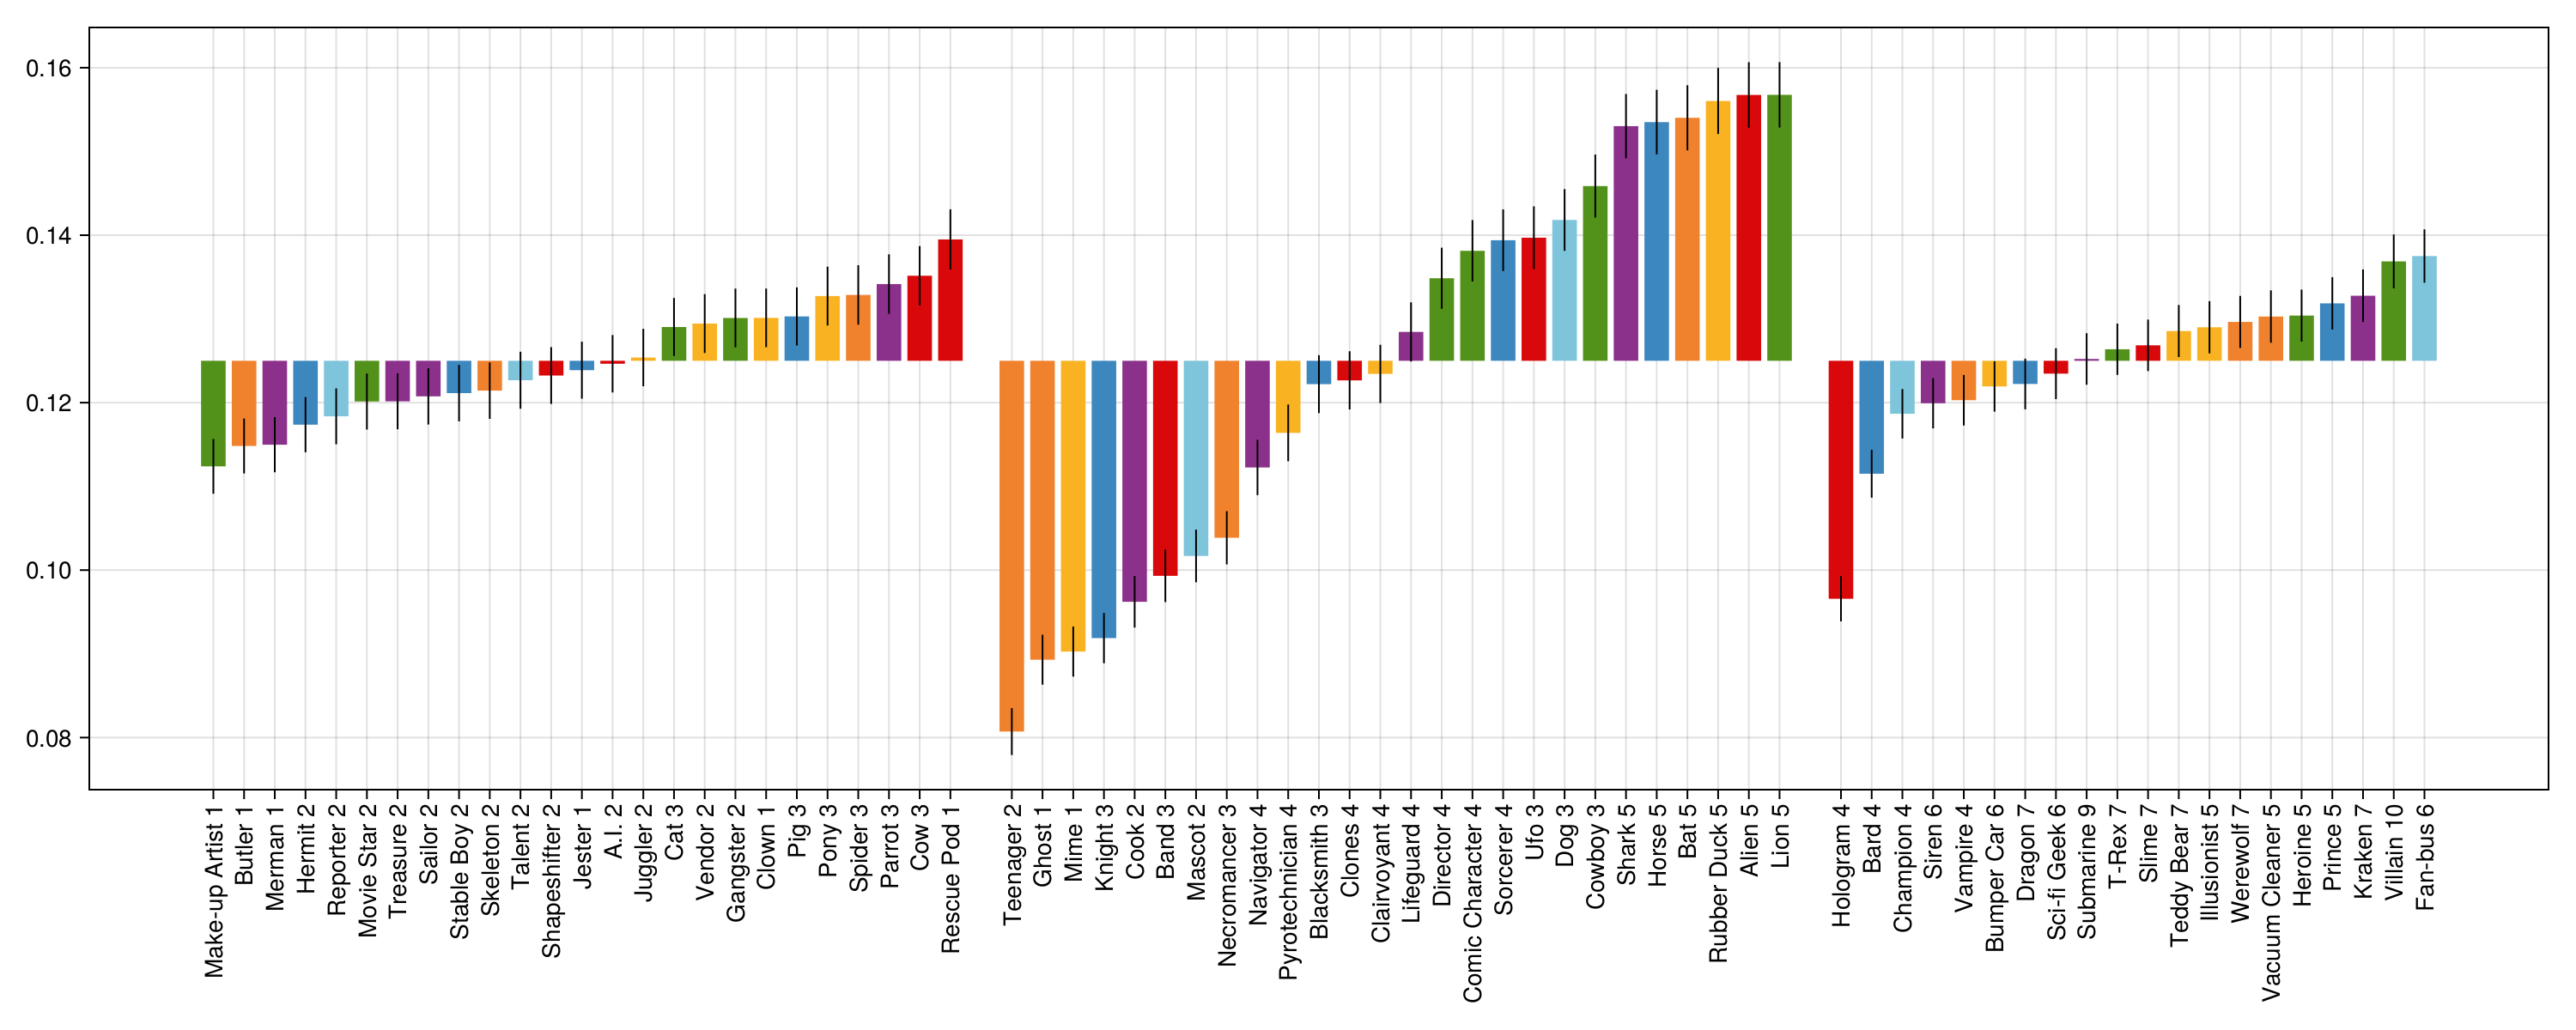

In [81]:
# ucards = copy(abccards)
ucards = abccards[sort(1:length(abccards), by = i -> (tier(abccards[i]), winrates[i]))]
# sort!(ucards, by = set)
i = 2
while i <= length(ucards)
    a = false#ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end

uinds = findfirst.(isequal.(abccards), Ref(ucards))
unplays = fill(NaN, length(ucards))
unplays[uinds] .= nplays;
unwins = fill(NaN, length(ucards))
unwins[uinds] .= nwins;
uwinrates = unwins ./ unplays;
uwinodds = uwinrates ./ (1 .- uwinrates);

fig = Figure(size = (1500,600))
xs = 1:length(ucards)
ax = Axis(fig[1,1], xticks = (xs[(!isempty).(name.(ucards))], (name.(ucards) .* " " .* string.(power.(ucards)))[(!isempty).(name.(ucards))]), xticklabelrotation = pi/2)

barplot!(ax, xs, uwinrates, linewidth = 3, color = setcolor.(ucards), fillto = 1/8)
errorbars!(ax, xs, uwinrates, sqrt.(uwinrates ./ unplays), linewidth = 1, color = :black, whiskerwidth = 0)

fig

In [34]:
save("out/fullgamewinrates.pdf", fig)

CairoMakie.Screen{PDF}


In [3]:
nselected_all = zeros(length(ch.cards))
nselected_winner = zeros(length(ch.cards))
nplayers = 8
nsamples = 10000

lk = ReentrantLock()
prog = Progress(nsamples)
Threads.@threads for i in 1:nsamples
    winner, points, players = runGame(nplayers = nplayers);

    lock(lk) do
        for card in unique(players[winner].deck.cards)
            nselected_winner[findfirst(isequal(card), ch.cards)] += 1
        end
        for player in players, card in unique(player.deck.cards)
            nselected_all[findfirst(isequal(card), ch.cards)] += 1
        end
    end
    next!(prog)
end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:00:07


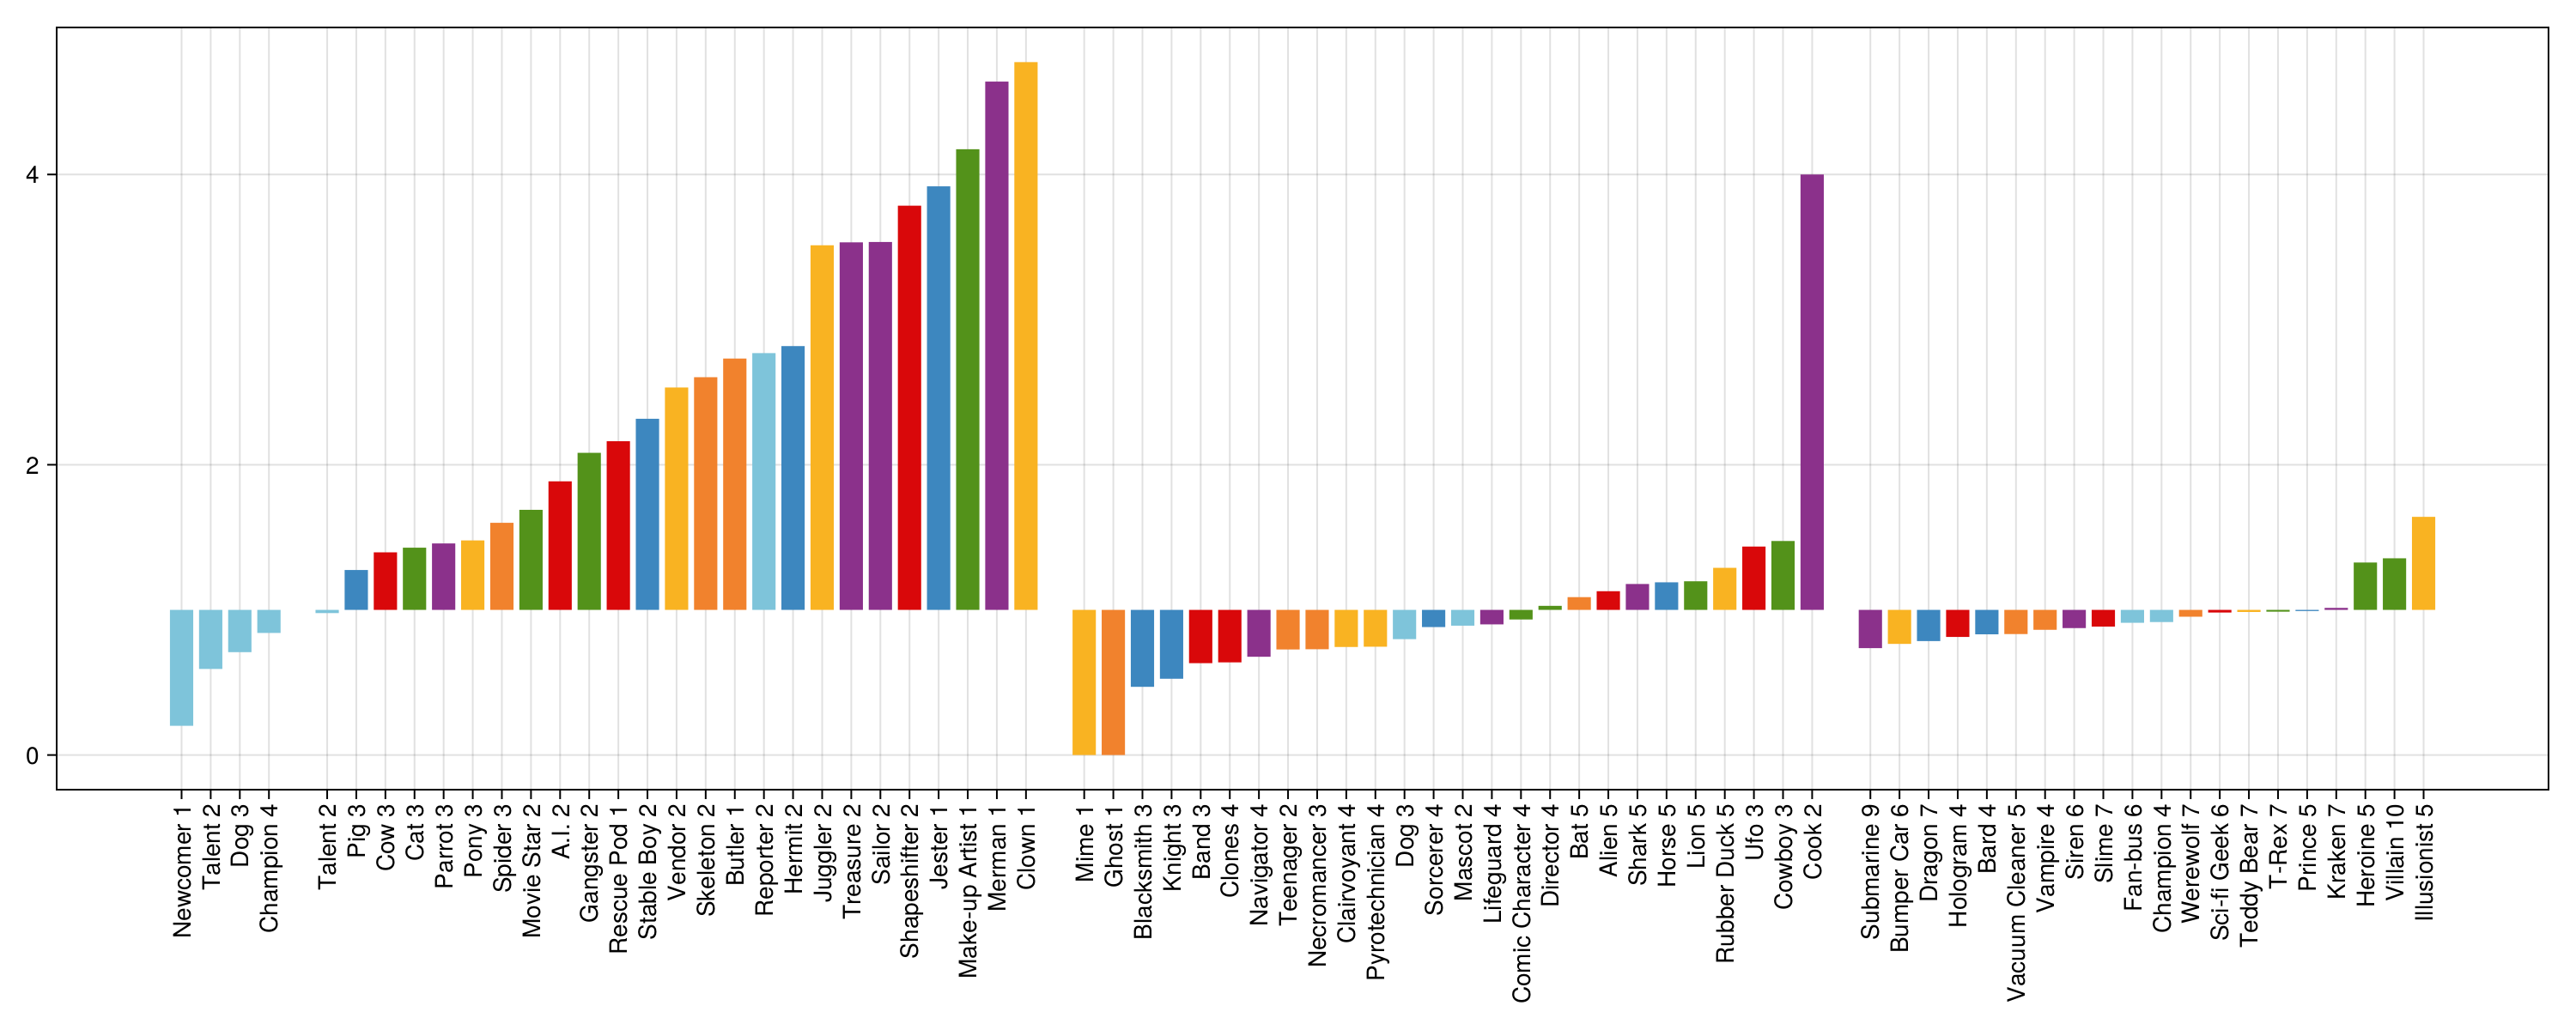

In [4]:
# ucards = copy(abccards)
ucards = ch.cards[sort(1:length(ch.cards), by = i -> (tier(ch.cards[i]), nselected_winner[i] / nselected_all[i]))]
# sort!(ucards, by = set)
i = 2
while i <= length(ucards)
    a = false#ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end

uinds = findfirst.(isequal.(ch.cards), Ref(ucards))
unselected_winner = fill(NaN, length(ucards)); unselected_winner[uinds] .= nselected_winner;
unselected_all = fill(NaN, length(ucards)); unselected_all[uinds] .= nselected_all;

fig = Figure(size = (1500,600))
xs = 1:length(ucards)
ax = Axis(fig[1,1], xticks = (xs[(!isempty).(name.(ucards))], (name.(ucards) .* " " .* string.(power.(ucards)))[(!isempty).(name.(ucards))]), xticklabelrotation = pi/2)

barplot!(ax, xs, 8unselected_winner ./ unselected_all, linewidth = 3, color = setcolor.(ucards), fillto = 1)

fig

In [75]:
ucards = copy(abccards)
sort!(ucards, by = tier)
i = 2
while i <= length(ucards)
    a = ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end
pushfirst!(ucards, Card())

uinds = findfirst.(isequal.(ch.cards), Ref(ucards))
uwinodds = fill(NaN, length(ucards))
uwinodds[uinds] .= winodds

upairwinodds = fill(NaN, length(ucards), length(ucards))
upairwinodds[uinds, uinds] .= pairwinodds;

In [74]:
pairs = ((x, y) -> (x, y)).(ch.cards, reshape(ch.cards, 1, :));
tierpairs = (cs -> tier.(cs)).(pairs)

# alldecks = reduce(vcat, decks)
prog = Progress(length(decks))
pairwinrates = ThreadsX.map(tierpairs, decks) do tp, ds
    next!(prog)
    isempty(ds) && return NaN
    state = State()
    w = mean(ds) do d
        winrate(d, rand.(sample(decks, Weights((tierpairs .== Ref(tp))[:]), 10)), nsamples = 10, state = state)
    end
end;

winrates = [mean(filter(!isnan, c)) for c in eachcol(pairwinrates)]

winodds = winrates ./ (1 .- winrates)
pairwinodds = pairwinrates ./ (1 .- pairwinrates);

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:00:14


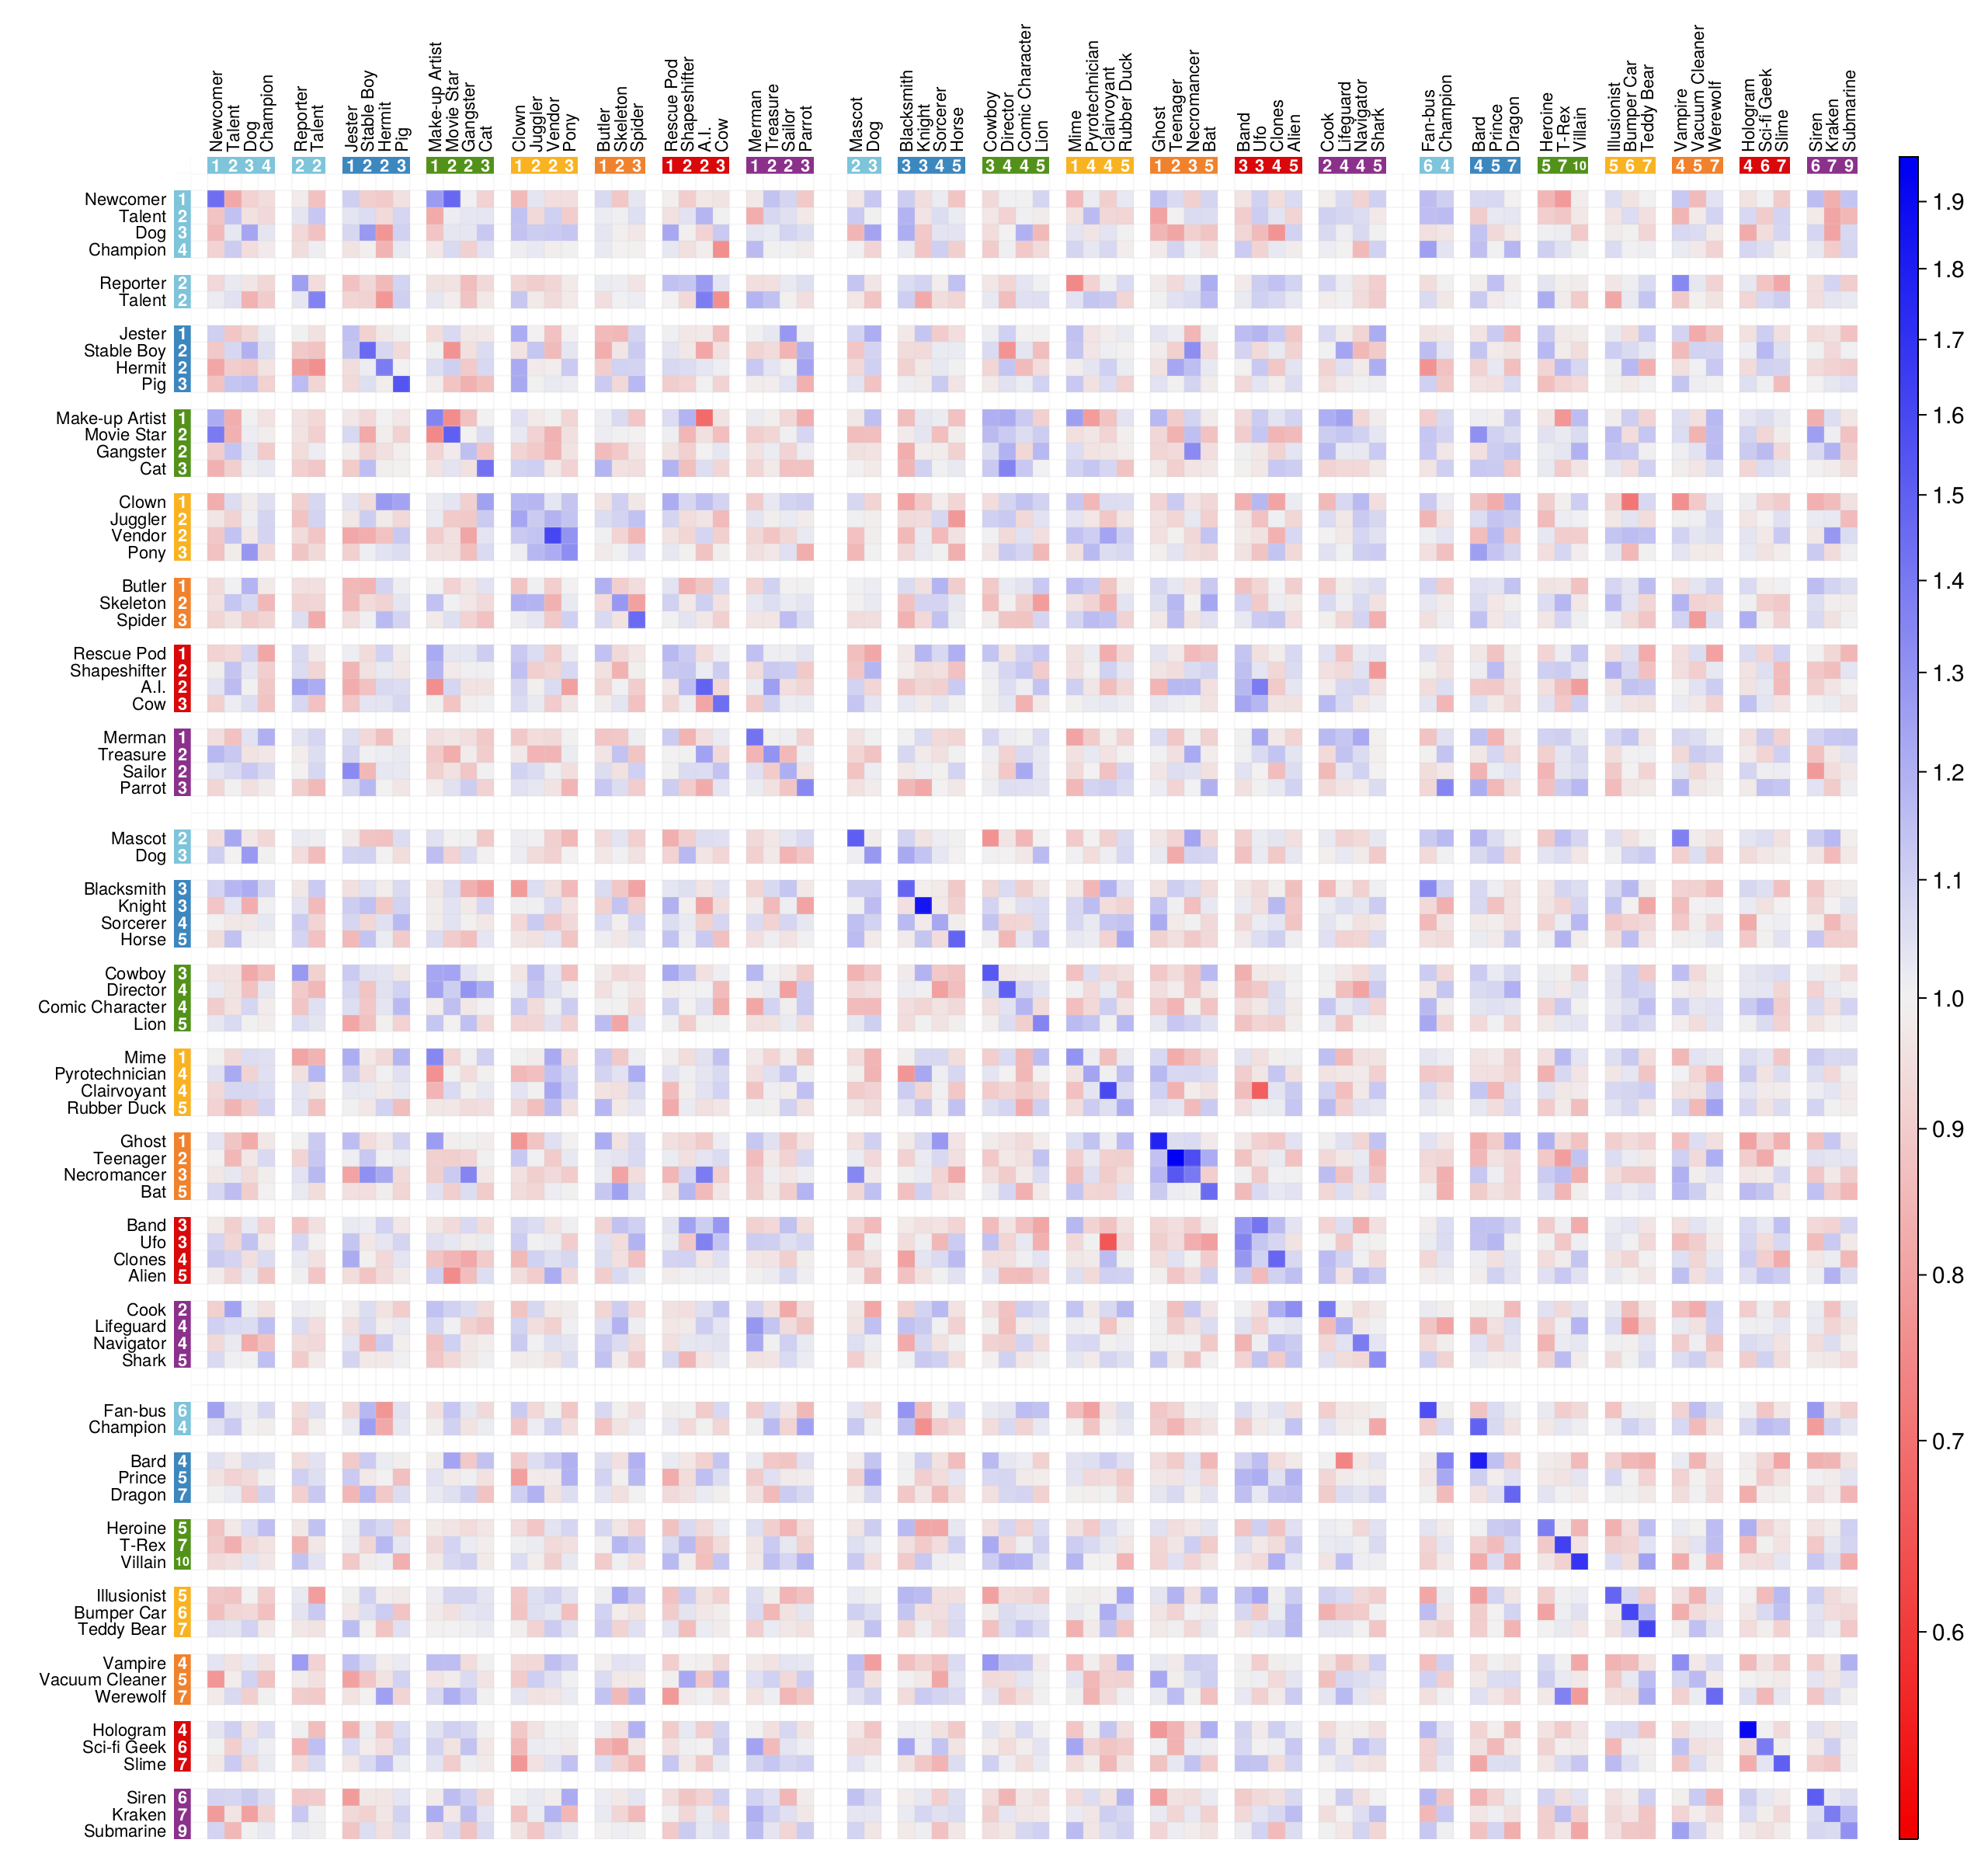

In [76]:
fig = Figure(size = (1280,1200), fontsize = 11)
ax = Axis(fig[1,1], aspect = 1,
    xticks = (1:length(ucards), name.(ucards)), xticklabelrotation = pi/2, xticksvisible = false, xgridvisible = false,
    yticks = (1:length(ucards), name.(ucards)), xaxisposition=:top, yreversed = true, yticksvisible = false, ygridvisible = false
)
hidespines!(ax)
xlims!(ax, -0.5, length(ucards) + 0.5)
ylims!(ax, length(ucards) + 0.5, -0.5)


ys = log10.(upairwinodds ./ uwinodds ./ uwinodds')

m = norm(filter(!isnan, ys), Inf)
plt = heatmap!(ax, ys, colorrange = (-m, m), colormap = reverse(RGB.(cgrad(:bwr).colors)) .* 0.95, nan_color = :transparent)

hlines!(ax, 0.5:length(ucards)+0.5, color = :lightgrey, alpha = 0.2, linewidth = 1)
vlines!(ax, 0.5:length(ucards)+0.5, color = :lightgrey, alpha = 0.2, linewidth = 1)
image!(ax, -0.5..0.5, 0.5..length(ucards) + 0.5, reshape(parse.(RGB, setcolor.(ucards)), 1, :), interpolate = false)
image!(ax, 0.5..length(ucards) + 0.5, -0.5..0.5, reshape(parse.(RGB, setcolor.(ucards)), :, 1), interpolate = false)

ts = string.(power.(ucards))
text!(ax, 1:length(ucards), zeros(length(ucards)), text = ts, color = :white, fontsize = ifelse.(length.(ts) .== 1, 11, 8), align = (:center, :center), font = :bold)
text!(ax, zeros(length(ucards)), 1:length(ucards), text = ts, color = :white, fontsize = ifelse.(length.(ts) .== 1, 11, 8), align = (:center, :center), font = :bold)

# Colorbar(fig[1,2], plt, ticklabelsize = 15, ticks = ([-1,0,1], ["0.1", "1", "10"]), minorticksvisible = true, minorticks = [log10.(0.1:0.1:0.9); log10.(1:1:10)])
Colorbar(fig[1,2], plt, ticklabelsize = 15, ticks = (log10.(0.1:0.1:2), string.(0.1:0.1:2)))

fig

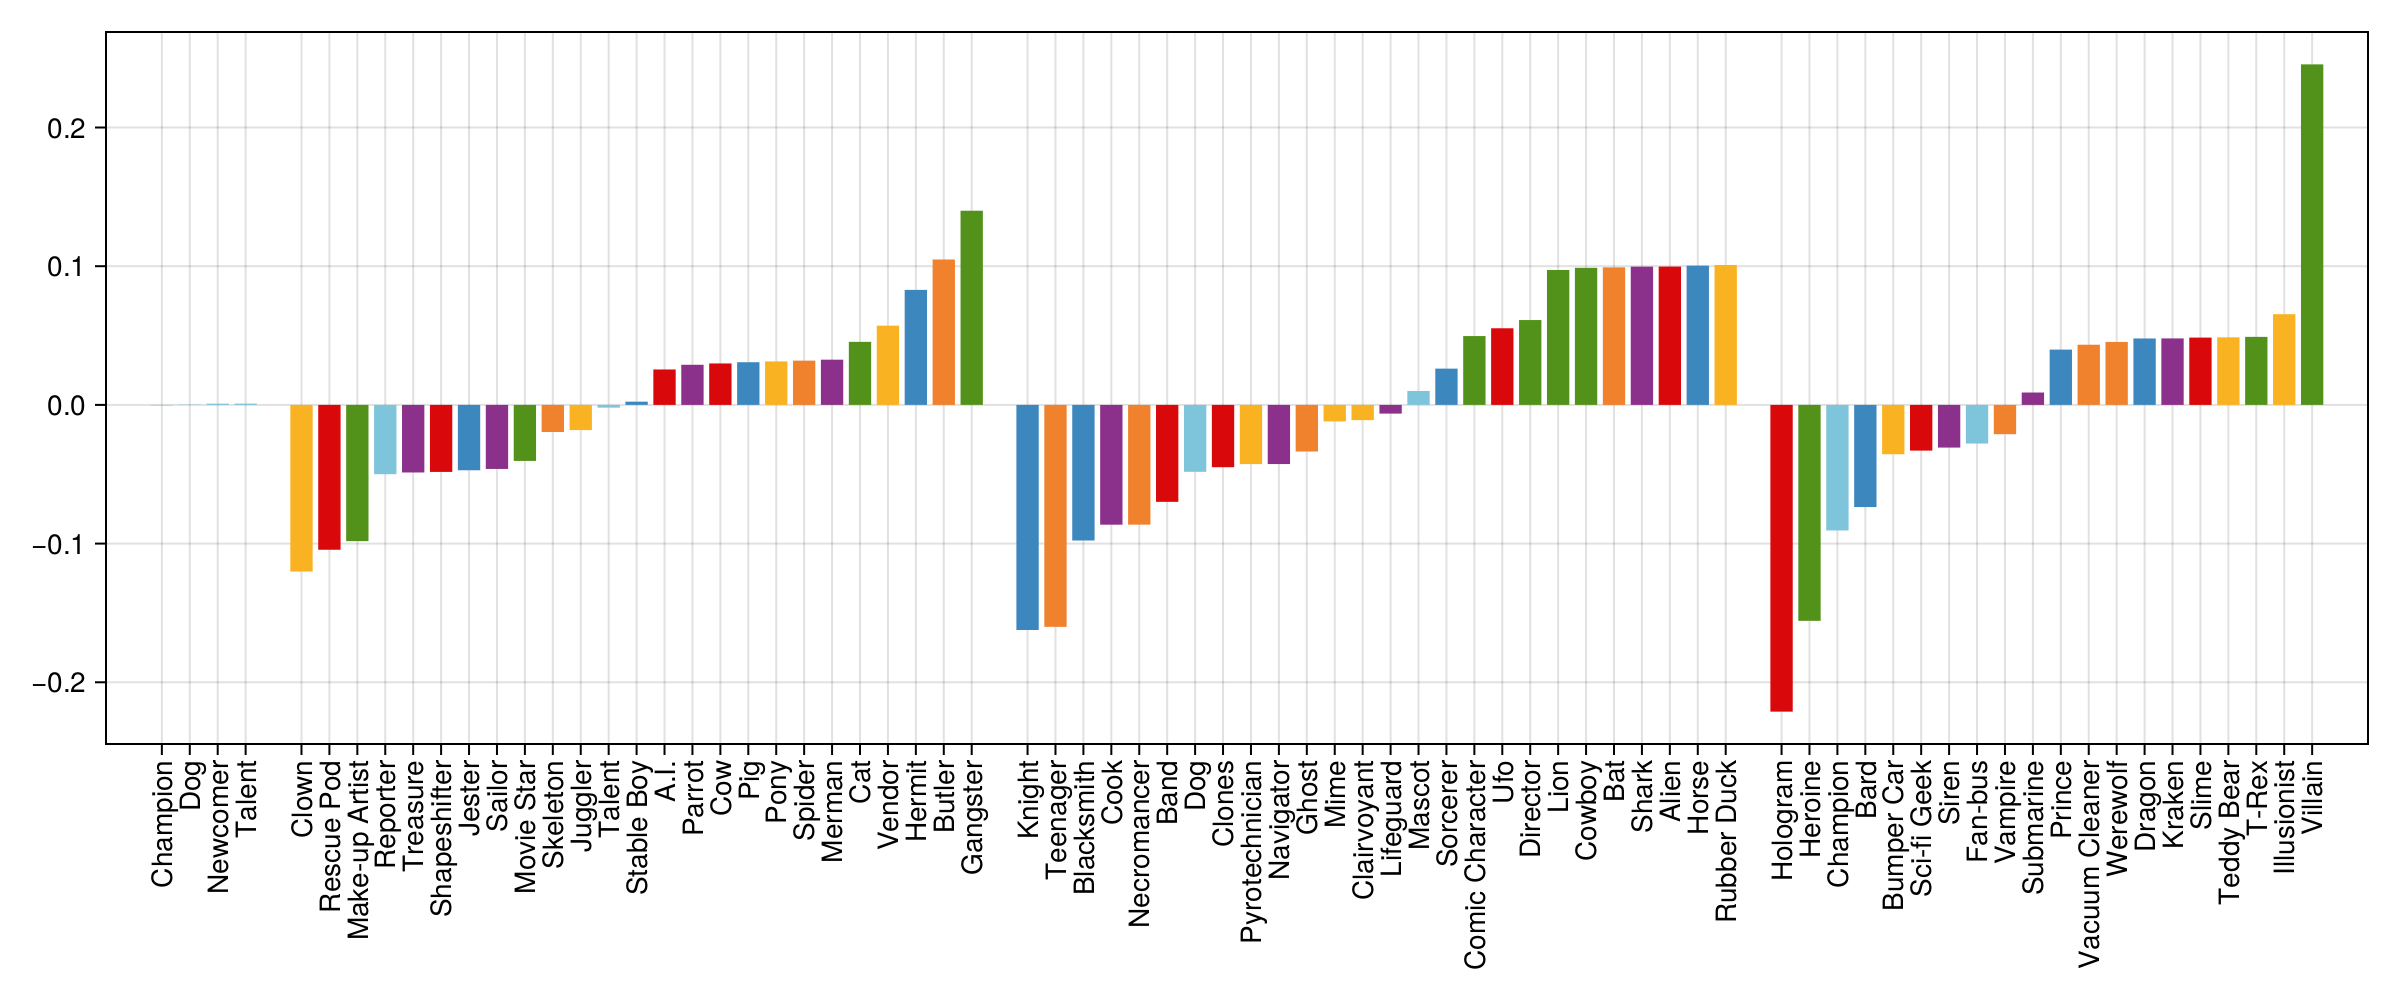

In [75]:
perm = sortperm(winodds)
allys = winodds[perm]
scards = ch.cards[perm]

perm = sortperm(scards, by = tier)

fig = Figure(size = (1200,500))

ax = Axis(fig[1,1], 
    xticks = ((1:length(scards)) .+ Int.(tier.(scards)[perm]), name.(scards)[perm]), xticklabelrotation = pi/2, 
)

xlims!(ax, -1, length(scards) + 5)
# ylims!(ax, low = 0)

offset = 0
for t in instances(Tier)[1:4]
    sel = tier.(scards) .== t
    ys = allys[sel]
    xs = offset .+ (1:length(ys))
    offset = maximum(xs) + 1
    barplot!(ax, xs, log10.(ys), linewidth = 3, color = setcolor.(scards[sel]), fillto = 0)
end
fig